In [2]:
#import relevant libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cv2 # pip install opencv-python 
from moviepy.editor import VideoFileClip #MoviePy is a Python library for video editing 

In [ ]:
# Extract frames from the video
def extract_frames(video_path, interval):
    clip = VideoFileClip(video_path)
    frames = []
    for t in np.arange(0, clip.duration, interval):
        frame = cv2.cvtColor(clip.get_frame(t), cv2.COLOR_RGB2GRAY)
        frames.append(frame)
    return frames

# Calculate optical flow
def calculate_flow(prev_frame, curr_frame):
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Detect corners in the previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_frame, mask = None, **feature_params)

    # If corners were detected, calculate optical flow
    if prev_pts is not None:
        curr_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_frame, curr_frame, prev_pts, None, **lk_params)
        valid_prev_pts = prev_pts[status == 1]
        valid_curr_pts = curr_pts[status == 1]

        # Calculate motion vectors
        motion_vectors = valid_curr_pts - valid_prev_pts

        # Calculate average motion vector
        avg_motion_vector = np.mean(motion_vectors, axis=0)

        # Ensure the result is a 2-dimensional array
        return avg_motion_vector.reshape(1, -1)

    return None

# Main processing function
def process_video(video_path, interval=0.1):
    frames = extract_frames(video_path, interval)
    data = []

    for i in range(1, len(frames)):
        flow = calculate_flow(frames[i-1], frames[i])
        if flow is not None:
            data.append([i, flow[0, 0], flow[0, 1]])

    return pd.DataFrame(data, columns=['Frame', 'FlowX', 'FlowY'])

# First 5 mins

In [ ]:
# Process the video 

video_path = '20231215122825_000553.MP4'
df = process_video(video_path)
df.to_csv('vibration_data.csv', index=False)

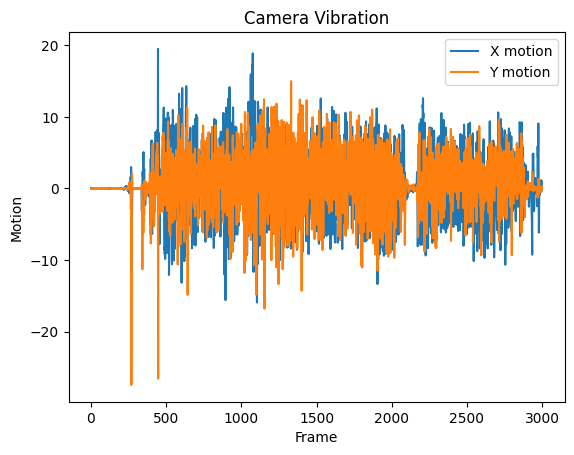

In [3]:
df = pd.read_csv('/work/vibration_data.csv')
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the X and Y motion vectors
ax.plot(df['Frame'], df['FlowX'], label='X motion')
ax.plot(df['Frame'], df['FlowY'], label='Y motion')

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

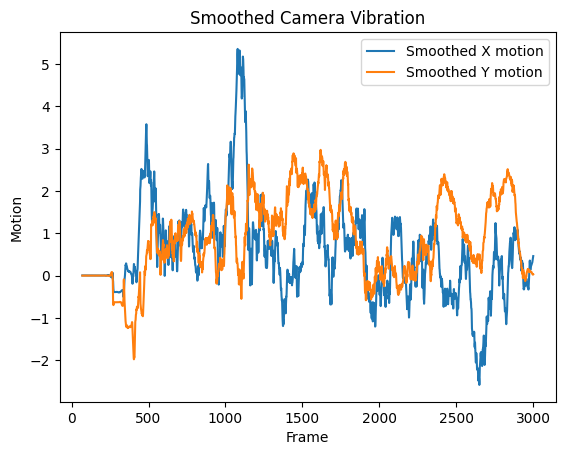

In [4]:
# Define the size of the moving average window
window_size = 70

# Apply the moving average to the X and Y motion vectors
df['SmoothFlowX'] = df['FlowX'].rolling(window_size).mean()
df['SmoothFlowY'] = df['FlowY'].rolling(window_size).mean()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the smoothed X and Y motion vectors
ax.plot(df['Frame'], df['SmoothFlowX'], label='Smoothed X motion')
ax.plot(df['Frame'], df['SmoothFlowY'], label='Smoothed Y motion')

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Smoothed Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

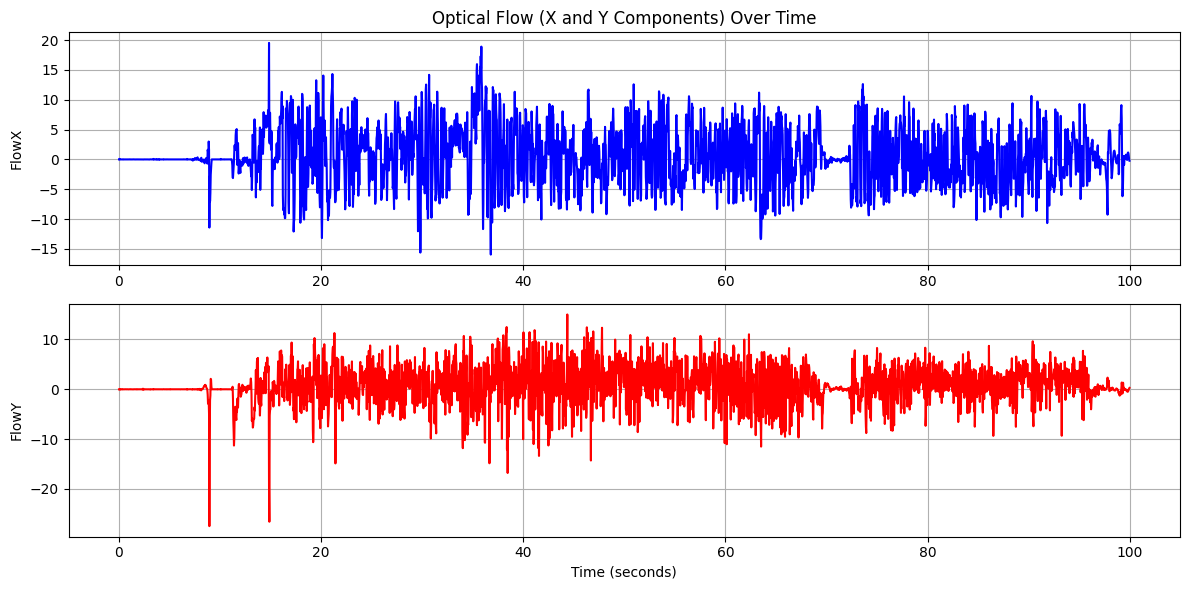

In [5]:
# Assuming standard video frame rate to calculate time (e.g., 30 frames per second)
# This can be adjusted if the actual frame rate is known
frame_rate = 30  # This is an assumption; 

# Calculate time for each frame
df['Time'] = df['Frame'] / frame_rate

# Plotting FlowX and FlowY against Time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df['Time'], df['FlowX'], label='FlowX', color='blue')
plt.title('Optical Flow (X and Y Components) Over Time')
plt.ylabel('FlowX')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['Time'], df['FlowY'], label='FlowY', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('FlowY')
plt.grid(True)

plt.tight_layout()
plt.show()


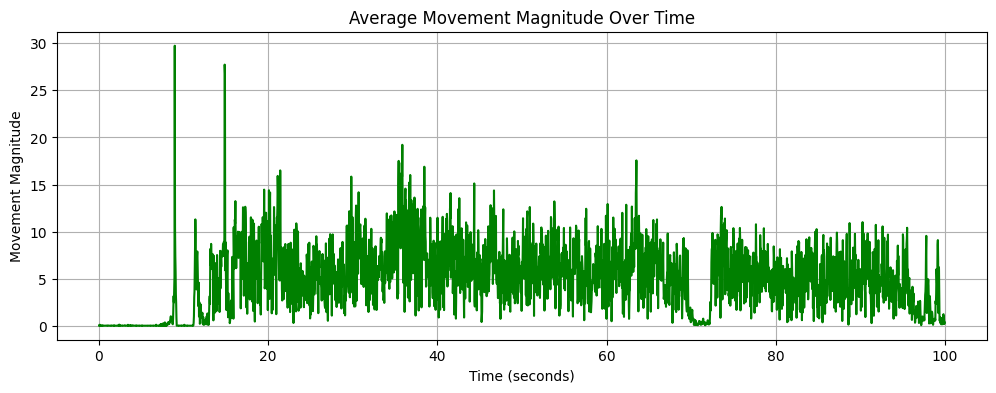

In [6]:
# Calculate the magnitude of the optical flow (average movement) for each frame
df['MovementMagnitude'] = np.sqrt(df['FlowX']**2 + df['FlowY']**2)

# Plotting Movement Magnitude against Time
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['MovementMagnitude'], label='Movement Magnitude', color='green')
plt.title('Average Movement Magnitude Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Movement Magnitude')
plt.grid(True)
plt.show()


# Whole Journey

In [7]:
file_paths = [
    '/work/20231215122825_000553-vibration_data.csv',
    '/work/20231215123326_000554-vibration_data.csv',
    '/work/20231215123826_000555-vibration_data.csv',
    '/work/20231215124326_000556-vibration_data.csv',
    '/work/20231215124826_000557-vibration_data.csv',
    '/work/20231215125326_000558-vibration_data.csv',
    '/work/20231215125826_000559-vibration_data.csv',
    '/work/20231215130326_000560-vibration_data.csv',
    '/work/20231215130826_000561-vibration_data.csv',
    '/work/20231215131326_000562-vibration_data.csv'
]


# Initialize an empty DataFrame
df1 = pd.DataFrame()

# Initialize a variable to keep track of the frame number
frame_number = 0

# Loop through the file paths, read each file, adjust the frame number, and append it to the DataFrame
for file_path in file_paths:
    temp_df = pd.read_csv(file_path)

    # Check if the 'Frame' column exists and adjust it
    if 'Frame' in temp_df.columns:
        temp_df['Frame'] += frame_number
        frame_number = temp_df['Frame'].max()

    df1 = pd.concat([df1, temp_df], ignore_index=True)

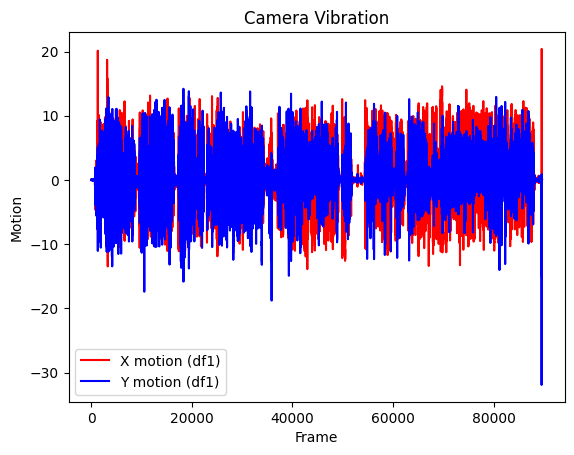

In [8]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the X and Y motion vectors
ax.plot(df1['Frame'], df1['FlowX'], label='X motion (df1)', color='red')
ax.plot(df1['Frame'], df1['FlowY'], label='Y motion (df1)', color='blue')


# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Camera Vibration')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

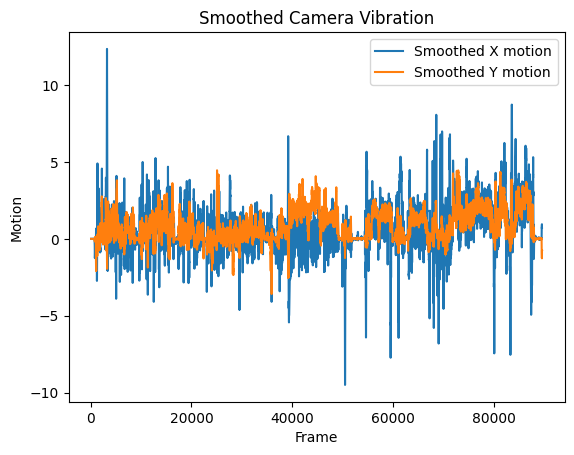

In [9]:
# Define the size of the moving average window
window_size = 70

# Apply the moving average to the X and Y motion vectors
df1['SmoothFlowX'] = df1['FlowX'].rolling(window_size).mean()
df1['SmoothFlowY'] = df1['FlowY'].rolling(window_size).mean()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the smoothed X and Y motion vectors
ax.plot(df1['Frame'], df1['SmoothFlowX'], label='Smoothed X motion')
ax.plot(df1['Frame'], df1['SmoothFlowY'], label='Smoothed Y motion')

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Smoothed Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

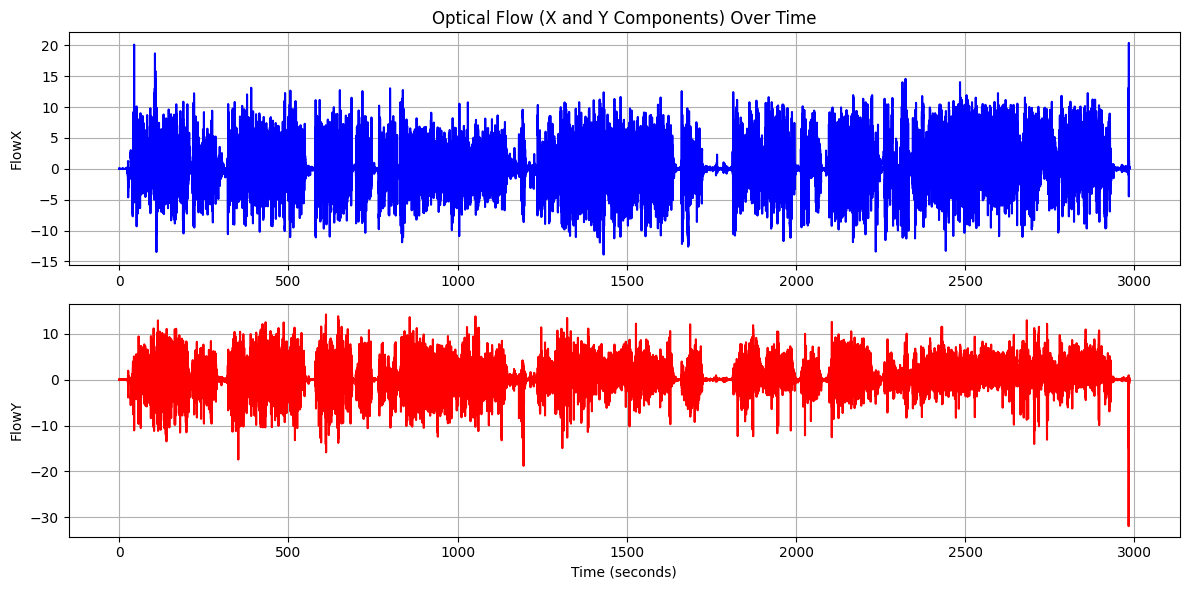

In [10]:
# Assuming standard video frame rate to calculate time (e.g., 30 frames per second)
# This can be adjusted if the actual frame rate is known
frame_rate = 30  # This is an assumption; 

# Calculate time for each frame
df1['Time'] = df1['Frame'] / frame_rate

# Plotting FlowX and FlowY against Time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df1['Time'], df1['FlowX'], label='FlowX', color='blue')
plt.title('Optical Flow (X and Y Components) Over Time')
plt.ylabel('FlowX')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df1['Time'], df1['FlowY'], label='FlowY', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('FlowY')
plt.grid(True)

plt.tight_layout()
plt.show()

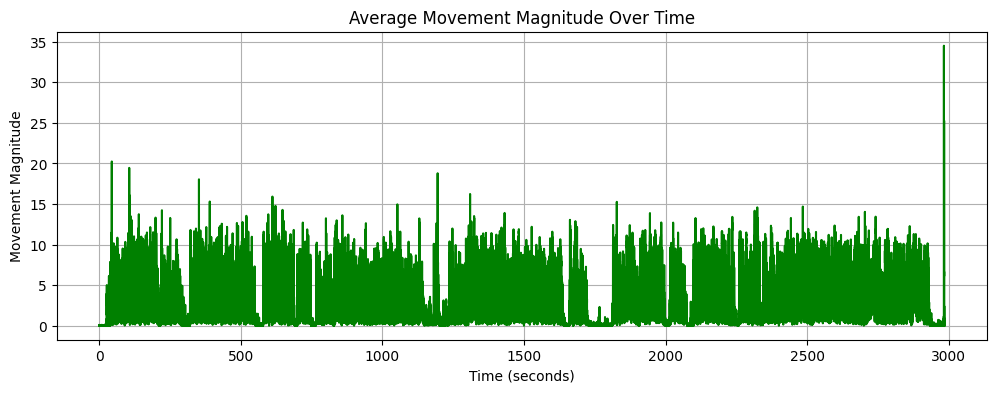

In [11]:
# Calculate the magnitude of the optical flow (average movement) for each frame
df1['MovementMagnitude'] = np.sqrt(df1['FlowX']**2 + df1['FlowY']**2)

# Plotting Movement Magnitude against Time
plt.figure(figsize=(12, 4))
plt.plot(df1['Time'], df1['MovementMagnitude'], label='Movement Magnitude', color='green')
plt.title('Average Movement Magnitude Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Movement Magnitude')
plt.grid(True)
plt.show()

# Whole Journey with cuts (waiting, preptime etc.)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_paths = [
    '/work/MileEnd-Hyde-Park-iPhoneAudio_0-300_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_300-600_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_600-900_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_900-1200_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_1200-1500_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_1500-1800_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_1800-2100_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_2100-2400_vibration_data.csv',
    '/work/MileEnd-Hyde-Park-iPhoneAudio_2400-2498_vibration_data.csv'
]


# Initialize an empty DataFrame
df2 = pd.DataFrame()

# Loop through the file paths, read each file, adjust the frame number, and append it to the DataFrame
for file_path in file_paths:
    temp_df = pd.read_csv(file_path)
    df2 = pd.concat([df2, temp_df], ignore_index=True)

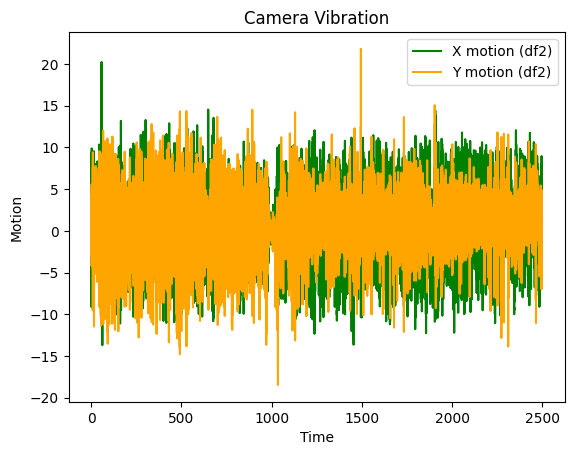

In [13]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the X and Y motion vectors
ax.plot(df2['Time'], df2['FlowX'], label='X motion (df2)', color='green')
ax.plot(df2['Time'], df2['FlowY'], label='Y motion (df2)', color='orange')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Motion')
ax.set_title('Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

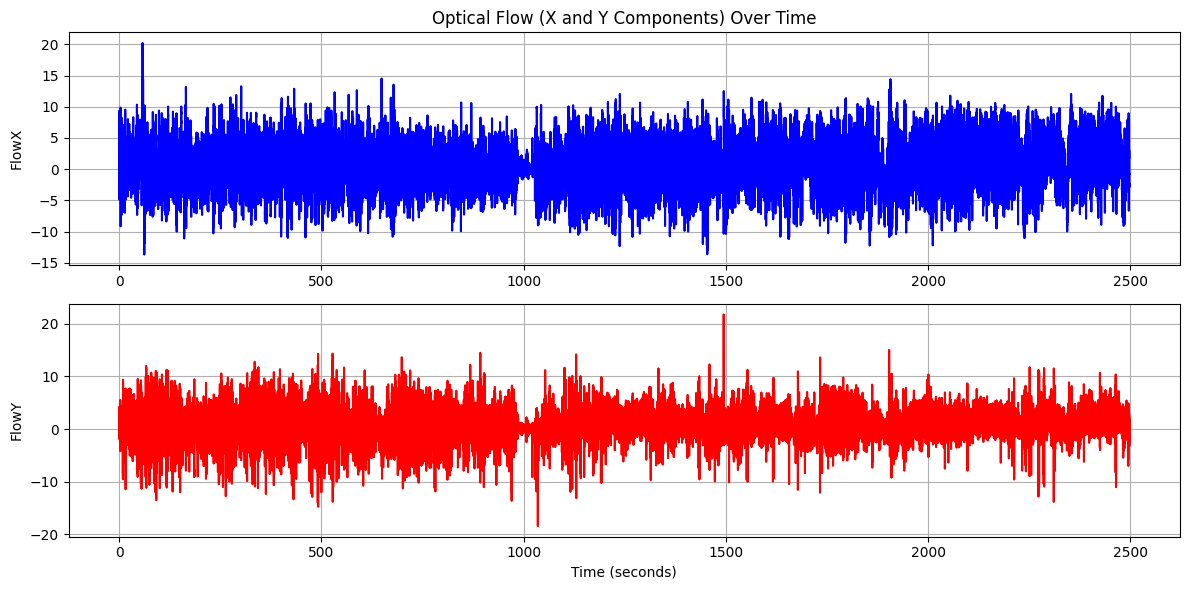

In [14]:
 # Plotting FlowX and FlowY against Time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df2['Time'], df2['FlowX'], label='FlowX', color='blue')
plt.title('Optical Flow (X and Y Components) Over Time')
plt.ylabel('FlowX')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df2['Time'], df2['FlowY'], label='FlowY', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('FlowY')
plt.grid(True)

plt.tight_layout()

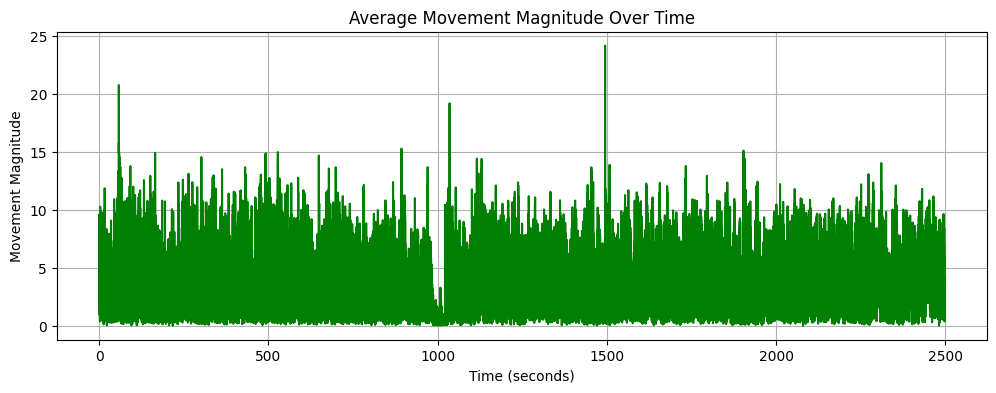

In [16]:
# Calculate the magnitude of the optical flow (average movement) for each frame
df2['MovementMagnitude'] = np.sqrt(df2['FlowX']**2 + df2['FlowY']**2)

# Plotting Movement Magnitude against Time
plt.figure(figsize=(12, 4))
plt.plot(df2['Time'], df2['MovementMagnitude'], label='Movement Magnitude', color='green')
plt.title('Average Movement Magnitude Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Movement Magnitude')
plt.grid(True)
plt.show()

In [17]:
# Dividing the dataset into 42 one-minute segments and calculating the average for each segment
# This is achieved by grouping the data into 1-minute intervals

# Group by each minute (60 seconds)
grouped_by_minute = df2.groupby(df2['Time'] // 60)
average_per_minute = grouped_by_minute['MovementMagnitude'].mean().reset_index()

# Renaming columns for clarity
average_per_minute.columns = ['Minute', 'AverageMovementMagnitude']

print(np.array(average_per_minute['AverageMovementMagnitude']))


[4.00119655 4.17252114 3.79815901 2.96773977 4.050666   3.93183588
 4.10995265 4.04619974 4.46028397 3.63977717 3.21230746 4.16187707
 3.63943848 3.61933332 2.83461654 2.85298218 1.71016563 2.9265036
 3.9807762  3.98724824 3.83819931 4.10789371 3.62671855 3.45241286
 3.52920635 3.76365974 3.96202179 3.87461885 3.74041496 4.20218719
 4.27180795 3.90968446 3.89057804 3.89421164 4.25201007 3.92577296
 3.98688663 3.99725614 3.72422893 4.23566598 4.60154262 4.26985491]


In [18]:
# Dividing the dataset into 42 one-minute segments and calculating the average for each segment
# This is achieved by grouping the data into 1-minute intervals

# Group by each minute (60 seconds)
grouped_by_minute = df2.groupby(df2['Time'] // 60)
average_per_minute_Y = grouped_by_minute['FlowY'].mean().reset_index()

# Renaming columns for clarity
average_per_minute_Y.columns = ['Minute', 'AverageMovementY']

print(np.array(average_per_minute_Y['AverageMovementY']))


[0.39293813 0.84402464 0.39066011 0.55130048 0.32249378 0.89227173
 1.10925168 0.5860231  0.49600205 0.45379925 0.04304775 0.57145854
 0.18994818 0.17023888 0.55105804 0.45205998 0.27849752 0.14190485
 0.63697684 1.81939019 1.56669125 2.29995579 1.25900226 1.271208
 0.39287766 1.03888694 1.52744634 1.10701298 0.33511102 1.35319567
 1.25995883 0.51787619 0.79550426 1.54701147 1.21530709 1.75648705
 1.46618637 0.99724336 1.23540464 1.10448807 2.28899185 1.51549394]


In [19]:
# Dividing the dataset into 42 one-minute segments and calculating the average for each segment
# This is achieved by grouping the data into 1-minute intervals

# Group by each minute (60 seconds)
grouped_by_minute = df2.groupby(df2['Time'] // 60)
average_per_minute_X = grouped_by_minute['FlowX'].mean().reset_index()

# Renaming columns for clarity
average_per_minute_X.columns = ['Minute', 'AverageMovementX']

print(np.array(average_per_minute_X['AverageMovementX']))

[ 1.53716059  0.26784434  0.61641098 -0.13837814  0.87661882  0.66822192
  0.39981286  0.76631844  0.71701985  0.53609446  0.48419132  0.16588326
  0.57460326  0.12695295 -0.14640689  0.2724504   0.27353479 -0.39353454
 -0.08422006 -0.07667522 -0.043327   -0.07068009  0.20965568  0.26547769
 -0.54562005  1.02786278  1.18398385  0.32668525  1.20932496  0.50157206
  0.58860017  0.33837779  1.04469124  1.03872033  1.35341965  1.80922436
  1.47198775  0.23073487  1.67741079  1.53742208  2.54618787  1.25211409]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9ead3db-108d-4aeb-849b-a4d7596e0484' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>